In [1]:
import svgutils.compose as sc

svg = sc.SVG('../artifacts/double_border.svg')

In [4]:
svg.width

40.0

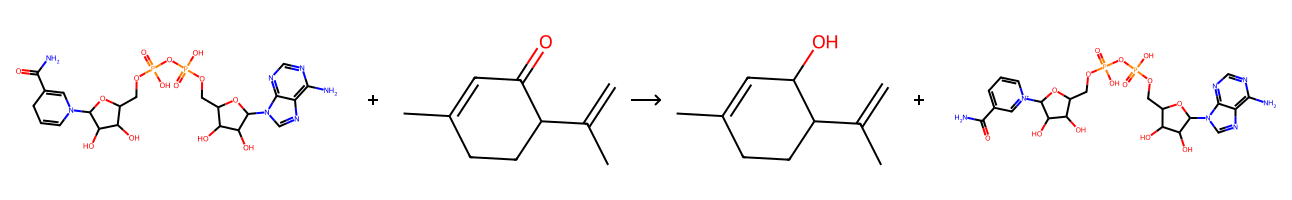

In [5]:
from IPython.display import SVG, display
display(SVG('/home/stef/bottle/artifacts/imgs/rxns/20434.svg'))

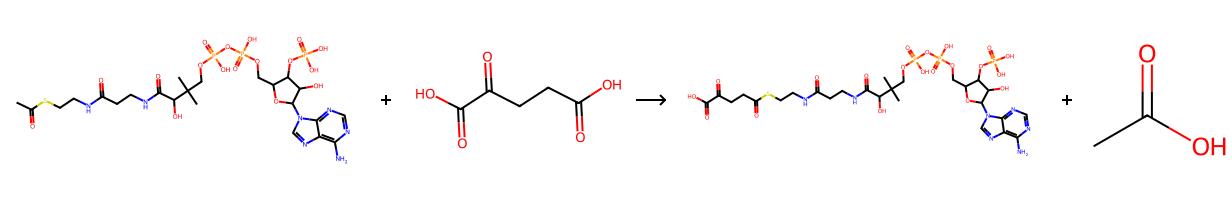

In [6]:
display(SVG('/home/stef/bottle/artifacts/imgs/rxns/R0fdfa9445e86162b989f752e8151dee801a5e489ca37f13abccbb18d7af5c5cc.svg'))


In [1]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_pwy_svg
from src.utils import ensure_dirs
import pickle
import subprocess
import pandas as pd

In [2]:
def thresholded_uniprot_strings(path_enzymes, enzyme_validation_threshold):
    uniprot_strings = []
    for rxn_enzymes in path_enzymes:
        if rxn_enzymes:
            up_str = ", ".join([e.uniprot_id for e in rxn_enzymes if e.validation_score >= enzyme_validation_threshold])
            uniprot_strings.append(up_str)
        else:
            uniprot_strings.append(None)

    return uniprot_strings

In [3]:
# Params
starters = 'alpha_ketoglutarate'
targets = 'hopa'
generations = 2
ts = 0

expansion_dir = '../data/processed_expansions/'
fn = f"{starters}_to_{targets}_gen_{generations}_tan_sample_{ts}_n_samples_1000.pkl" # Expansion file name

# Load processed expansions
with open(expansion_dir + fn, 'rb') as f:
    pe = pickle.load(f)


In [4]:
print(pe.starter_target_pairs)
print(len(pe._st2paths[('alpha_ketoglutarate', 'hopa')]))

{('alpha_ketoglutarate', 'hopa')}
15


In [4]:
to_vis = {}
for st_pair in pe.starter_target_pairs:
    starter, target = st_pair
    enzyme_validation_threshold = 1.0
    sort_by = ['prc_mcs']
    filter_by = {'mdf':0, 'enzyme_validation':enzyme_validation_threshold}

    paths = pe.get_paths_w_st(starter=starter,
                    target=target,
                    sort_by=sort_by,
                    filter_by=filter_by,
                    reduce_predicted_reactions='min'
                    )
    
    if len(paths) > 0:
        print(f"{len(paths)} for {st_pair}")
        to_vis[st_pair] = paths

5 for ('alpha_ketoglutarate', 'hopa')


In [53]:
sheets = []
sheetnames = []

for st_pair, paths in to_vis.items():
    print(st_pair)
    # Set up sheets headers & pwy svg outdir
    print("Generating svgs & csv")
    headers = ['id', 'starter', 'target', 'mdf', 'pwy_ave_mcs'] + [f"mcs_rxn_{g+1}" for g in range(generations)] + [f"uniprot_rxn_{g+1}" for g in range(generations)]
    pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-4]}/{'_'.join(st_pair)}/"
    ensure_dirs(pwy_svg_outdir)

    rows_for_sheet = []
    for path in paths:
        row = [] # One path
        up_strings = thresholded_uniprot_strings(pe.get_path_enzymes(path), enzyme_validation_threshold)
        prc_mcs = pe.get_path_prc_mcs(path) # Top-analogue prc_mcs for each predicted reaction in path 
        row += [path.id, path.starter, path.target, path.mdf, sum(prc_mcs) / len(prc_mcs)] # Append average prc_mcs

        # Append reaction prc_mcs
        for g in range(generations):
            if g < len(path.reaction_ids):
                row.append(prc_mcs[g])
            else:
                row.append(None)

        # Append uniprot strings
        for g in range(generations):
            if g < len(path.reaction_ids):
                row.append(up_strings[g])
            else:
                row.append(None)

        # Draw pathway svg 
        sma_hash_pairs = []
        for prid in path.reaction_ids:
            pr = pe.predicted_reactions[prid]
            analogue = pr.top_analogue()['analogue']
            sma_hash_pairs.append([(pr.smarts, prid), (analogue.smarts, analogue.id)])
        
        outpath = pwy_svg_outdir + f"{path.id:04}.svg"
        draw_pwy_svg(sma_hash_pairs, path.id, outpath)

        rows_for_sheet.append(row)

    # Make df for this st pair
    sheets.append(pd.DataFrame(rows_for_sheet, columns=headers).set_index('id'))
    sheetnames.append("_".join(st_pair))

    # Convert svgs to pdfs
    print("Generating pdfs")
    tmp_pdf_outdir = f"../artifacts/tmp_pdfs/{fn[:-4]}/{'_'.join(st_pair)}/"
    ensure_dirs(tmp_pdf_outdir)
    for path in paths:
        cmd = ["inkscape", f"--export-pdf={tmp_pdf_outdir}{path.id:04}.pdf", f"{pwy_svg_outdir}{path.id:04}.svg"]
        subprocess.run(cmd)

    # Concatenate pdfs
    print("Concatenating pdfs")
    pwy_pdf_outdir = f"../artifacts/pwy_pdfs/{fn[:-4]}/"
    ensure_dirs(pwy_pdf_outdir)
    cat_pdf_fn = pwy_pdf_outdir + '_'.join(st_pair) + '.pdf'
    individual_pwys = [f"{tmp_pdf_outdir}{path.id:04}.pdf" for path in paths]

    cmd = ["pdfunite", *individual_pwys, cat_pdf_fn]
    subprocess.run(cmd)

# Concatenate sheets into xls
print("Saving xlsx")
writer = pd.ExcelWriter(f"../artifacts/pwy_xls/{fn[:-4]}" + '.xlsx') # Arbitrary output name
for i, df in enumerate(sheets):
    df.to_excel(writer, sheet_name=sheetnames[i])
writer.save()

# Remove stuff
dirs = ['../artifacts/' + elt for elt in ['tmp_pdfs', 'rxn_svgs', 'pwy_svgs', 'mol_svgs']]
for elt in dirs:
    subprocess.run([f"rm -r {elt}/*"], shell=True)

('alpha_ketoglutarate', 'hopa')
Generating svgs & csv
Generating pdfs


Failed to get connection
** (org.inkscape.Inkscape:424694): CRITICAL **: 14:23:20.047: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:424694): CRITICAL **: 14:23:20.047: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:424694): CRITICAL **: 14:23:20.047: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:424716): CRITICAL **: 14:23:20.328: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.Inkscape:424716): CRITICAL **: 14:23:20.328: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed

** (org.inkscape.Inkscape:424716): CRITICAL **: 14:23:20.328: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Failed to get connection
** (org.inkscape.Inkscape:424744): CRITICAL **: 14:23:20.564: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed

** (org.inkscape.

Concatenating pdfs
Saving xlsx


In [54]:
for kr in pr.analogues:
    for e in kr.enzymes:
        print(e.uniprot_id, e.organism)

Q8WVX9 Homo sapiens (Human)
Q5R834 Pongo abelii (Sumatran orangutan) (Pongo pygmaeus abelii)
Q7ZXF5 Xenopus laevis (African clawed frog)
Q5ZM72 Gallus gallus (Chicken)
Q922J9 Mus musculus (Mouse)
Q66H50 Rattus norvegicus (Rat)
Q8WVX9 Homo sapiens (Human)
Q5R834 Pongo abelii (Sumatran orangutan) (Pongo pygmaeus abelii)
Q7ZXF5 Xenopus laevis (African clawed frog)
Q5ZM72 Gallus gallus (Chicken)
Q922J9 Mus musculus (Mouse)
Q66H50 Rattus norvegicus (Rat)
A1ZAI3 Drosophila melanogaster (Fruit fly)
Q8WVX9 Homo sapiens (Human)
B9TSP7 Arabidopsis thaliana (Mouse-ear cress)
Q0P5J1 Bos taurus (Bovine)
Q08891 Arabidopsis thaliana (Mouse-ear cress)
Q5R834 Pongo abelii (Sumatran orangutan) (Pongo pygmaeus abelii)
Q96K12 Homo sapiens (Human)
Q7ZXF5 Xenopus laevis (African clawed frog)
Q7TNT2 Mus musculus (Mouse)
Q5ZM72 Gallus gallus (Chicken)
Q922J9 Mus musculus (Mouse)
Q66H50 Rattus norvegicus (Rat)
A1ZAI3 Drosophila melanogaster (Fruit fly)
Q8WVX9 Homo sapiens (Human)
Q0P5J1 Bos taurus (Bovine)
Q5R